In [10]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [11]:
def train(autoencoder, dataloader, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print("Epoch %d/%d" % (epoch + 1, epochs))
        for x, _ in tqdm(dataloader):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [12]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

dataloader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=False),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, dataloader)

Epoch 0/20


100%|██████████| 469/469 [00:06<00:00, 69.48it/s]


Epoch 1/20


100%|██████████| 469/469 [00:07<00:00, 64.65it/s]


Epoch 2/20


100%|██████████| 469/469 [00:10<00:00, 45.98it/s]


Epoch 3/20


100%|██████████| 469/469 [00:07<00:00, 58.82it/s]


Epoch 4/20


100%|██████████| 469/469 [00:08<00:00, 55.13it/s]


Epoch 5/20


100%|██████████| 469/469 [00:06<00:00, 73.05it/s]


Epoch 6/20


100%|██████████| 469/469 [00:07<00:00, 61.98it/s]


Epoch 7/20


100%|██████████| 469/469 [00:06<00:00, 72.05it/s]


Epoch 8/20


100%|██████████| 469/469 [00:07<00:00, 62.95it/s]


Epoch 9/20


100%|██████████| 469/469 [00:07<00:00, 64.64it/s]


Epoch 10/20


100%|██████████| 469/469 [00:07<00:00, 63.32it/s]


Epoch 11/20


100%|██████████| 469/469 [00:07<00:00, 64.56it/s]


Epoch 12/20


100%|██████████| 469/469 [00:08<00:00, 54.32it/s]


Epoch 13/20


100%|██████████| 469/469 [00:07<00:00, 63.27it/s]


Epoch 14/20


100%|██████████| 469/469 [00:06<00:00, 72.60it/s]


Epoch 15/20


100%|██████████| 469/469 [00:07<00:00, 62.68it/s]


Epoch 16/20


100%|██████████| 469/469 [00:07<00:00, 63.59it/s]


Epoch 17/20


100%|██████████| 469/469 [00:07<00:00, 62.89it/s]


Epoch 18/20


100%|██████████| 469/469 [00:06<00:00, 72.33it/s]


Epoch 19/20


100%|██████████| 469/469 [00:07<00:00, 62.13it/s]


In [13]:
def plot_latent(autoencoder, dataloader, num_batches=100):
    for i, (x, y) in enumerate(dataloader):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

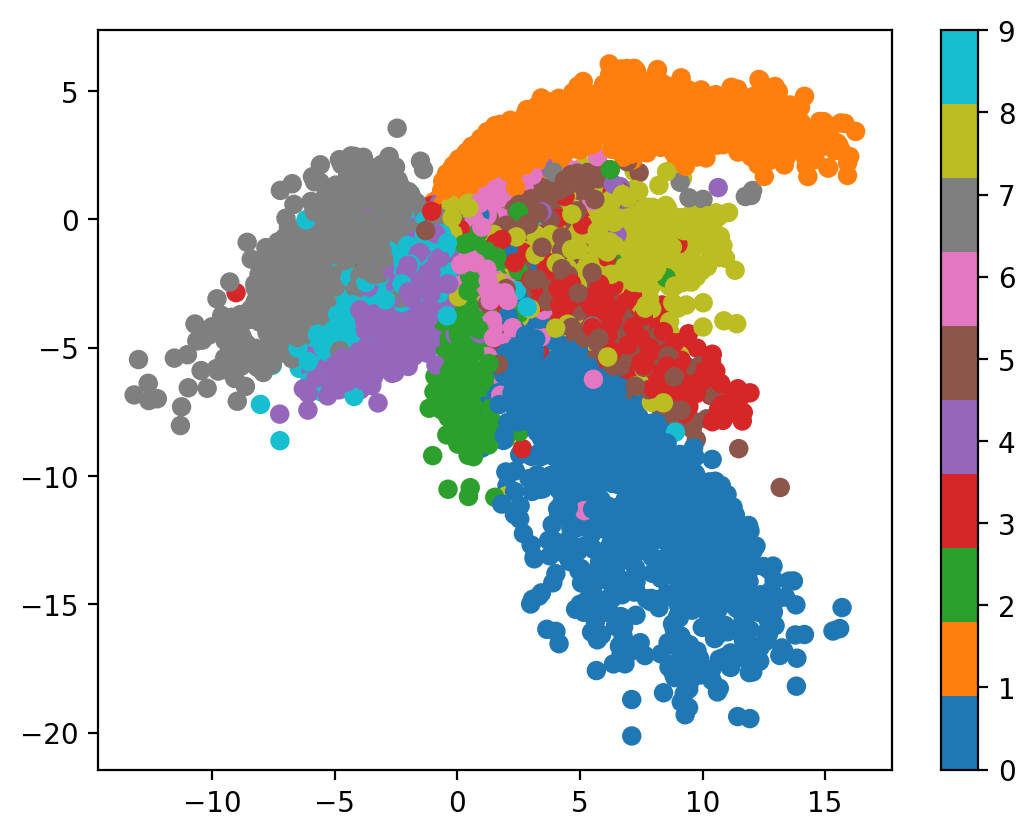

In [14]:
plot_latent(autoencoder, dataloader)

In [15]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

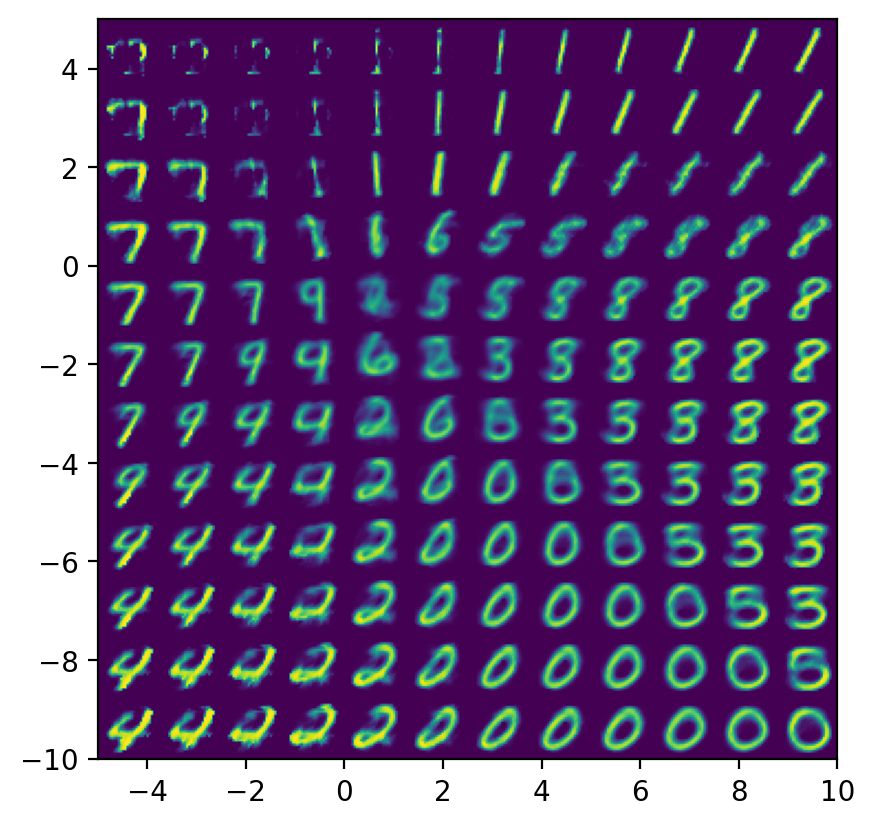

In [16]:
plot_reconstructed(autoencoder)